# Control platform angle with full state feedback

Do all imports:

In [ ]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [ ]:
simulator = ae353_platform.Simulator(
    display=True,
    roll=0.,
)

Define equilibrium point and state-space model.

In [ ]:
# Equilibrium point
(q1e, v1e, taue) = (np.pi / 6, 0., 0.)

# State-space model
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0.], [1.]])
print(f'A =\n{A}\n\nB =\n{B}')

Design controller.

In [ ]:
# Eigenvalue placement
K = signal.place_poles(A, B, [-2., -5.]).gain_matrix
print(f'K =\n{K}\n')

Implement controller.

In [ ]:
class Controller:
    def __init__(self, K, q1e, v1e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Get state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
        ])
        
        # Get input
        u = - self.K @ x
        
        # Get torque
        tau = u[0]
        
        # Get and return actuator command
        wheel_torque = -tau
        return wheel_torque

Test controller in simulation.

In [ ]:
# Create controller
controller = Controller(K, q1e, v1e, taue)

# Choose initial conditions
(q1i, v1i) = (0., 0.)

# Reset simulator
simulator.reset(
    platform_angle=q1i,
    platform_velocity=v1i,
    wheel_angle=0.,
    wheel_velocity=0.,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=10.,
)

Show results.

In [ ]:
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
tau = - data['wheel_torque']
x1 = q1 - q1e
x2 = v1 - v1e

fig, (ax_x1, ax_x2, ax_tau) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax_x1.plot(t, x1, label='$x_1$', linewidth=4)

ax_x2.plot(t, x2, label='$x_2$', linewidth=4)

ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')

ax_x1.grid()
ax_x1.legend(fontsize=16, loc='upper right')
ax_x1.tick_params(labelsize=14)
ax_x1.set_ylim(-1, 1)

ax_x2.grid()
ax_x2.legend(fontsize=16, loc='upper right')
ax_x2.tick_params(labelsize=14)
ax_x2.set_ylim(-1, 1)

ax_tau.grid()
ax_tau.legend(fontsize=16, loc='upper right')
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()

# Control platform angle with partial state feedback (linear sensor model)

Do all imports:

In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform_sensors

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Dec 10 2021 09:55:58


Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [2]:
simulator = ae353_platform_sensors.Simulator(
    display=True,
    roll=0.,
    sensor_noise=0.,
)

Define equilibrium point and state-space model.

In [3]:
# Equilibrium point
(q1e, v1e, taue) = (np.pi / 6, 0., 0.)

# State-space model (dynamics)
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0.], [1.]])
print(f'A =\n{A}\n\nB =\n{B}')

# State-space model (sensors)
C = np.array([[1., 0.]])
print(f'\nC =\n{C}')

A =
[[0. 1.]
 [0. 0.]]

B =
[[0.]
 [1.]]

C =
[[1. 0.]]


Design controller.

In [16]:
# Eigenvalue placement
K = signal.place_poles(A, B, [-1. + 2. * 1j, -1. - 2. * 1j]).gain_matrix
print(f'K =\n{K}\n')

K =
[[5. 2.]]



Check that the system is observable.

In [10]:
Wo = np.block([[C], [C @ A]])

print(Wo)

[[1. 0.]
 [0. 1.]]


In [11]:
np.linalg.matrix_rank(Wo)

2

Design observer.

In [17]:
# L = np.array([[10.], [1.]])

# Eigenvalue placement
L = signal.place_poles(A.T, C.T, [-2., -3.]).gain_matrix.T
print(f'L =\n{L}\n')

L =
[[5.]
 [6.]]



In [18]:
F = np.block([[A - B @ K, - B @ K],
              [np.zeros((2, 2)), A - L @ C]])

print(F)

[[ 0.  1.  0.  0.]
 [-5. -2. -5. -2.]
 [ 0.  0. -5.  1.]
 [ 0.  0. -6.  0.]]


In [19]:
print(linalg.eigvals(F))

[-1.+2.j -1.-2.j -3.+0.j -2.+0.j]


Implement controller and observer.

In [7]:
class Controller:
    def __init__(self, A, B, C, K, L, q1e, v1e, taue):
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q1e = q1e
        self.v1e = v1e
        self.taue = taue
        
        self.variables_to_log = ['xhat']
    
    def reset(self):
        self.xhat = np.array([0., 0.])
    
    def run(
            self,
            t,
            platform_angle_measurement,
        ):
        
        # Find input
        u = - self.K @ self.xhat
        
        # Find measurement
        y = np.array([platform_angle_measurement - q1e])
        
        # Find state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
        
        # Find actuator command
        tau = u[0] + self.taue
        
        wheel_torque = -tau
        return wheel_torque

Test controller *and observer* in simulation.

In [8]:
# Create controller
controller = Controller(A, B, C, K, L, q1e, v1e, taue)

# Choose initial conditions
(q1i, v1i) = (0., 0.)

# Reset simulator
simulator.reset(
    platform_angle=q1i,
    platform_velocity=v1i,
    wheel_angle=0.,
    wheel_velocity=0.,
    sensor_noise=0.1,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=10.,
)

Show results.

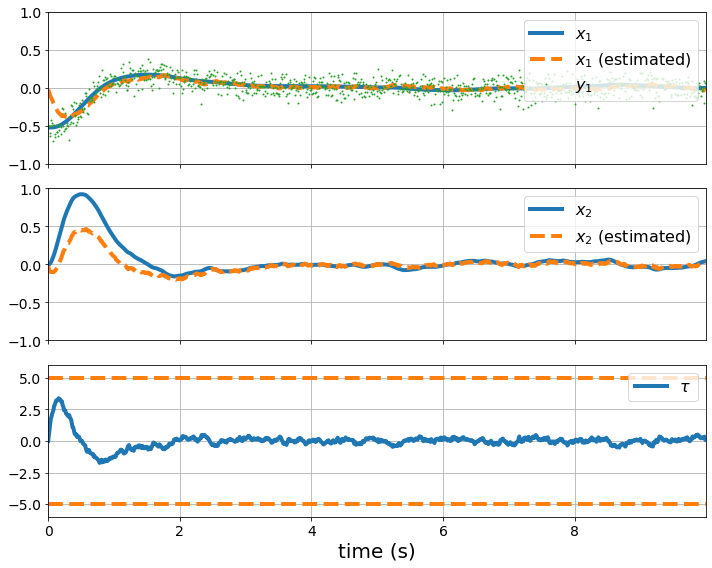

In [9]:
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
tau = - data['wheel_torque']
q1_meas = data['platform_angle_measurement']
y1 = q1_meas - q1e
x1 = q1 - q1e
x2 = v1 - v1e
xhat = data['xhat']

fig, (ax_x1, ax_x2, ax_tau) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
ax_x1.plot(t, xhat[:, 0], '--', label=r'$x_1$ (estimated)', linewidth=4)
ax_x1.plot(t, y1, '.', markersize=2, label='$y_1$')

ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
ax_x2.plot(t, xhat[:, 1], '--', label=r'$x_2$ (estimated)', linewidth=4)

ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')

ax_x1.grid()
ax_x1.legend(fontsize=16, loc='upper right')
ax_x1.tick_params(labelsize=14)
ax_x1.set_ylim(-1, 1)

ax_x2.grid()
ax_x2.legend(fontsize=16, loc='upper right')
ax_x2.tick_params(labelsize=14)
ax_x2.set_ylim(-1, 1)

ax_tau.grid()
ax_tau.legend(fontsize=16, loc='upper right')
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()

# Control platform angle with partial state feedback (nonlinear sensor model)

Do all imports:

In [ ]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform_nonlinearsensors

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [ ]:
simulator = ae353_platform_nonlinearsensors.Simulator(
    display=False,
    roll=0.,
    sensor_noise=0.,
)

Define equilibrium point and state-space dynamic model.

In [ ]:
# Equilibrium point
(q1e, v1e, taue) = (np.pi / 6, 0., 0.)

# State-space model (dynamics)
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0.], [1.]])
print(f'A =\n{A}\n\nB =\n{B}')

Define outputs and their equilibrium values.

In [ ]:
# Variables
q1, v1, tau = sym.symbols('q1, v1, tau')

# Outputs
o = sym.Matrix([sym.sin(q1)])

# Equilibrium
o_num = sym.lambdify([q1, v1, tau], o)
o_e = o_num(q1e, v1e, taue)

Show outputs.

In [ ]:
o

Show equilibrium value of outputs.

In [ ]:
print(o_e)

Linearize sensor model.

In [ ]:
C_num = sym.lambdify([q1, v1, tau], o.jacobian([q1, v1]))
C = C_num(q1e, v1e, taue)

print(f'\nC =\n{C}')

Design controller.

In [ ]:
# Eigenvalue placement
K = signal.place_poles(A, B, [-2., -5.]).gain_matrix
print(f'K =\n{K}\n')

Design observer.

In [ ]:
# Eigenvalue placement
L = signal.place_poles(A.T, C.T, [-2., -5.]).gain_matrix.T
print(f'L =\n{L}\n')

Implement controller and observer.

In [ ]:
class Controller:
    def __init__(self, A, B, C, K, L, q1e, v1e, taue):
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q1e = q1e
        self.v1e = v1e
        self.taue = taue
        
        self.variables_to_log = ['xhat']
    
    def reset(self):
        self.xhat = np.array([0., 0.])
    
    def run(
            self,
            t,
            platform_angle_measurement,
        ):
        
        # Find input
        u = - self.K @ self.xhat
        
        # Find measurement
        y = np.array([np.sin(platform_angle_measurement) - np.sin(q1e)])
        
        # Find state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
        
        # Find actuator command
        tau = u[0] + self.taue
        
        wheel_torque = -tau
        return wheel_torque

Test controller *and observer* in simulation.

In [ ]:
# Create controller
controller = Controller(A, B, C, K, L, q1e, v1e, taue)

# Choose initial conditions
(q1i, v1i) = (0., 0.)

# Reset simulator
simulator.reset(
    platform_angle=q1i,
    platform_velocity=v1i,
    wheel_angle=0.,
    wheel_velocity=0.,
    sensor_noise=0.1,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=10.,
)

Show results.

In [ ]:
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
tau = - data['wheel_torque']
q1_meas = data['platform_angle_measurement']
y1 = q1_meas - q1e
x1 = q1 - q1e
x2 = v1 - v1e
xhat = data['xhat']

fig, (ax_x1, ax_x2, ax_tau) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
ax_x1.plot(t, xhat[:, 0], '--', label=r'$x_1$ (estimated)', linewidth=4)
ax_x1.plot(t, y1, '.', markersize=2, label='$y_1$')

ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
ax_x2.plot(t, xhat[:, 1], '--', label=r'$x_2$ (estimated)', linewidth=4)

ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')

ax_x1.grid()
ax_x1.legend(fontsize=16, loc='upper right')
ax_x1.tick_params(labelsize=14)
ax_x1.set_ylim(-1, 1)

ax_x2.grid()
ax_x2.legend(fontsize=16, loc='upper right')
ax_x2.tick_params(labelsize=14)
ax_x2.set_ylim(-1, 1)

ax_tau.grid()
ax_tau.legend(fontsize=16, loc='upper right')
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()